In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import requests
import json
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve

from sklearn.utils.class_weight import compute_sample_weight

In [2]:
all_seasons = []

for season in range(2023, 2024):
    summary_url = f"https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId={season}{season+1}%20and%20gameTypeId=2"

    try:
        summary_resp = requests.get(summary_url)
        summary_resp.raise_for_status() 
        summary_json =  summary_resp.json()

        if summary_json['data']:
            df_summary = DataFrame(summary_json['data'])
            all_seasons.append(df_summary)
            df_summary['season'] = f"{season}-{season + 1}"
            print(f"Successfully fetched data for season {season}-{season+1}")
        else:
            print(f"No data returned for season {season}-{season + 1}")
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for season {season}-{season + 1}: {e}")

if all_seasons:
    nhl_api_df = pd.concat(all_seasons, ignore_index=True)
    nhl_api_df = nhl_api_df.groupby('playerId').agg({
            'playerId': 'first',
            'skaterFullName': 'first',
            'positionCode': 'first',
            'gamesPlayed': 'sum',
            'assists': 'sum',
            'otGoals': 'sum',
            'gameWinningGoals': 'sum',
        }).reset_index(drop = True)
    
print(nhl_api_df)

Successfully fetched data for season 2023-2024
     playerId     skaterFullName positionCode  gamesPlayed  assists  otGoals  \
0     8470600         Ryan Suter            D           82       15        0   
1     8470604        Jeff Carter            C           72        4        0   
2     8470610        Zach Parise            L           30        5        0   
3     8470613        Brent Burns            D           82       33        0   
4     8470621        Corey Perry            R           54       10        0   
..        ...                ...          ...          ...      ...      ...   
919   8484314       Jiri Smejkal            L           20        1        0   
920   8484321  Nikolas Matinpalo            D            4        0        0   
921   8484325    Waltteri Merela            C           19        0        0   
922   8484326        Patrik Koch            D            1        0        0   
923   8484911        Collin Graf            R            7        2      

In [3]:
nhl_api_df = nhl_api_df.loc[(nhl_api_df['positionCode'] != 'D') & (nhl_api_df['gamesPlayed'] >= 60)]
nhl_api_df = nhl_api_df.reset_index(drop = True)
nhl_api_df = nhl_api_df.fillna(0)

nhl_api_df.rename(columns = {'gameWinningGoals': 'game_winning_goals'}, inplace = True)
nhl_api_df.rename(columns = {'otGoals': 'ot_goals'}, inplace = True)
nhl_api_df.rename(columns = {'skaterFullName': 'Player'}, inplace = True)
nhl_api_df['regulation_game_winning'] = nhl_api_df['game_winning_goals'] - nhl_api_df['ot_goals']

In [4]:
goals_up_one_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
goals_down_one_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
tied_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
total_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"

In [5]:
urls = {
    "goals_up_one": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'goals_up_by_one'),
    "goals_down_one": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'goals_down_by_one'),
    "tied": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'goals_when_tied'),
    "total": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'total_goals'),
}

dataframes = {}

for name, (url, new_column_name) in urls.items():
    df = pd.read_html(url, header=0, index_col=0, na_values=["-"])[0]
    df.rename(columns={'Goals': new_column_name}, inplace=True)
    dataframes[name] = df

goals_up_one_df = dataframes["goals_up_one"]
goals_down_one_df = dataframes["goals_down_one"]
goals_tied_df = dataframes["tied"]
total_df = dataframes["total"]

In [6]:
goals_up_one_df = goals_up_one_df[['Player', 'GP', 'goals_up_by_one']]
goals_down_one_df = goals_down_one_df[['Player', 'goals_down_by_one']]
goals_tied_df = goals_tied_df[['Player', 'goals_when_tied']]
total_df = total_df[['Player', 'total_goals', 'Shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'Rush Attempts', 'iCF', 'Rebounds Created']]

dfs_natural_stat = [goals_up_one_df, goals_down_one_df, goals_tied_df, total_df]

import functools as ft
merged_natural_stat = ft.reduce(lambda left, right: pd.merge(left, right, on='Player'), dfs_natural_stat)
merged_natural_stat = merged_natural_stat.loc[merged_natural_stat['GP'] >= 60]
merged_natural_stat.rename(columns={'Shots': 'shots'}, inplace=True)
merged_natural_stat.rename(columns={'Rush Attempts': 'rush_attempts'}, inplace=True)

In [7]:
natural_stat_names = ["Pat Maroon", "Alex Kerfoot", "Nicholas Paul", "Zach Sanford", "Alex Wennberg", "Mitchell Marner", "Zach Aston-Reese",  "Max Comtois", "Alexei Toropchenko", "Cameron Atkinson"]
nhl_names = ["Patrick Maroon", "Alexander Kerfoot", "Nick Paul", "Zachary Sanford", "Alexander Wennberg", "Mitch Marner", "Zachary Aston-Reese",  "Maxime Comtois", "Alexey Toropchenko", "Cam Atkinson"]
merged_natural_stat = merged_natural_stat.replace(natural_stat_names, nhl_names)

In [8]:
merged_natural_stat

,Player,GP,goals_up_by_one,goals_down_by_one,goals_when_tied,total_goals,shots,ixG,iFF,iSCF,iHDCF,rush_attempts,iCF,Rebounds Created
0,Jeff Carter,72,4,3,3,11,90,11.45,134,95,53,9,175,18
3,Joe Pavelski,82,7,4,10,27,194,28.18,261,232,130,7,329,34
4,Alex Ovechkin,79,7,2,7,31,272,29.89,395,245,83,17,605,64
5,Evgeni Malkin,82,3,6,6,27,199,23.56,280,218,82,6,401,47
7,Sidney Crosby,82,8,6,15,42,278,38.58,398,287,131,17,490,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,Logan Cooley,82,2,2,8,20,151,16.52,217,147,57,8,284,21
556,Juraj Slafkovsky,82,2,4,5,20,152,21.56,226,198,98,5,314,27
564,Andrei Kuzmenko,72,3,5,6,22,121,19.29,197,182,97,4,265,40
566,Connor Bedard,68,2,6,9,22,206,23.82,299,226,69,17,401,34


In [9]:
nhl_api_df

,playerId,Player,positionCode,gamesPlayed,assists,ot_goals,game_winning_goals,regulation_game_winning
0,8470604,Jeff Carter,C,72,4,0,4,4
1,8470794,Joe Pavelski,C,82,40,1,4,3
2,8471214,Alex Ovechkin,L,79,34,1,5,4
3,8471215,Evgeni Malkin,C,82,40,0,2,2
4,8471675,Sidney Crosby,C,82,52,0,3,3
...,...,...,...,...,...,...,...,...
311,8483431,Logan Cooley,C,82,24,1,2,1
312,8483515,Juraj Slafkovsky,L,82,30,0,2,2
313,8483808,Andrei Kuzmenko,L,72,24,1,4,3
314,8484144,Connor Bedard,C,68,39,1,2,1


In [10]:
merged_clutch_goals = nhl_api_df.merge(merged_natural_stat, on = 'Player', how = 'left')

In [11]:
merged_clutch_goals

,playerId,Player,positionCode,gamesPlayed,assists,ot_goals,game_winning_goals,regulation_game_winning,GP,goals_up_by_one,...,goals_when_tied,total_goals,shots,ixG,iFF,iSCF,iHDCF,rush_attempts,iCF,Rebounds Created
0,8470604,Jeff Carter,C,72,4,0,4,4,72,4,...,3,11,90,11.45,134,95,53,9,175,18
1,8470794,Joe Pavelski,C,82,40,1,4,3,82,7,...,10,27,194,28.18,261,232,130,7,329,34
2,8471214,Alex Ovechkin,L,79,34,1,5,4,79,7,...,7,31,272,29.89,395,245,83,17,605,64
3,8471215,Evgeni Malkin,C,82,40,0,2,2,82,3,...,6,27,199,23.56,280,218,82,6,401,47
4,8471675,Sidney Crosby,C,82,52,0,3,3,82,8,...,15,42,278,38.58,398,287,131,17,490,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,8483431,Logan Cooley,C,82,24,1,2,1,82,2,...,8,20,151,16.52,217,147,57,8,284,21
312,8483515,Juraj Slafkovsky,L,82,30,0,2,2,82,2,...,5,20,152,21.56,226,198,98,5,314,27
313,8483808,Andrei Kuzmenko,L,72,24,1,4,3,72,3,...,6,22,121,19.29,197,182,97,4,265,40
314,8484144,Connor Bedard,C,68,39,1,2,1,68,2,...,9,22,206,23.82,299,226,69,17,401,34


In [12]:
null_rows = merged_clutch_goals[merged_clutch_goals.isnull().any(axis=1)]
print("Rows with null values:")
print(null_rows)

Rows with null values:
Empty DataFrame
Columns: [playerId, Player, positionCode, gamesPlayed, assists, ot_goals, game_winning_goals, regulation_game_winning, GP, goals_up_by_one, goals_down_by_one, goals_when_tied, total_goals, shots, ixG, iFF, iSCF, iHDCF, rush_attempts, iCF, Rebounds Created]
Index: []

[0 rows x 21 columns]


In [14]:
merged_clutch_goals.drop(columns = 'GP', axis = 1, inplace = True)

In [18]:
columns = ['ot_goals', 'regulation_game_winning', 'assists', 'goals_up_by_one', 'goals_down_by_one', 'goals_when_tied', 'shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'rush_attempts','iCF']
for column in columns:
    per_game_string = f"{column}_per_game"
    merged_clutch_goals[per_game_string] = merged_clutch_goals[column] / merged_clutch_goals['gamesPlayed']


In [19]:
merged_clutch_goals['clutch_score'] = 0.3 * merged_clutch_goals['goals_when_tied_per_game'] + 0.3 * merged_clutch_goals['goals_down_by_one_per_game'] + 0.2 * merged_clutch_goals['goals_up_by_one_per_game'] + 0.1 * merged_clutch_goals['regulation_game_winning_per_game'] + 0.1 * merged_clutch_goals['ot_goals_per_game']

In [20]:
merged_clutch_goals['clutch_score'] *= 100
merged_clutch_goals['clutch_score_rank']  = merged_clutch_goals['clutch_score'].rank(ascending = False)
merged_clutch_goals['clutch_score'] = merged_clutch_goals['clutch_score'].apply(lambda x: round(x, 2))
merged_clutch_goals.sort_values('clutch_score_rank', inplace = True)
merged_clutch_goals[['Player','clutch_score', 'clutch_score_rank']].head(80)

,Player,clutch_score,clutch_score_rank
205,Auston Matthews,18.15,1.0
138,Sam Reinhart,15.49,2.0
150,David Pastrnak,13.78,3.0
166,Kyle Connor,12.92,4.0
197,Kirill Kaprizov,12.80,5.0
...,...,...,...
289,Jake Neighbours,6.62,76.0
113,Anthony Duclair,6.58,77.0
79,Mika Zibanejad,6.54,78.0
73,Brandon Saad,6.46,79.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


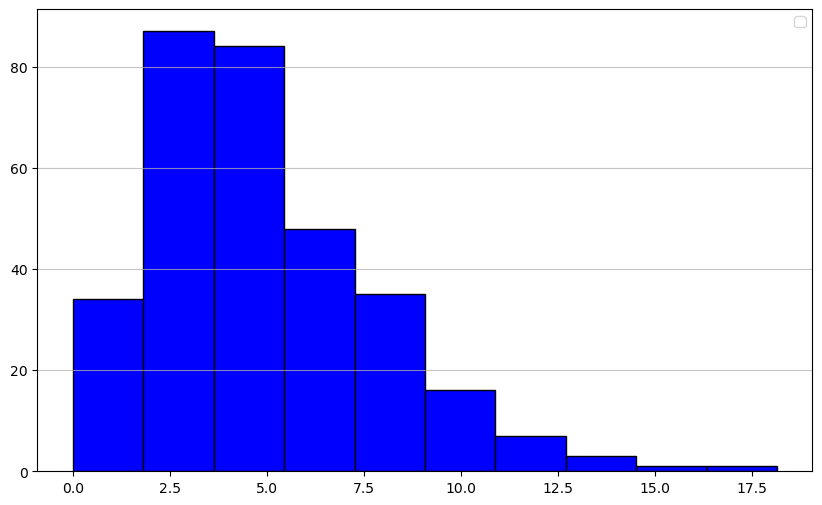

In [27]:
plt.figure(figsize=(10, 6))
plt.hist(merged_clutch_goals['clutch_score'], color='blue', edgecolor='black')
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()

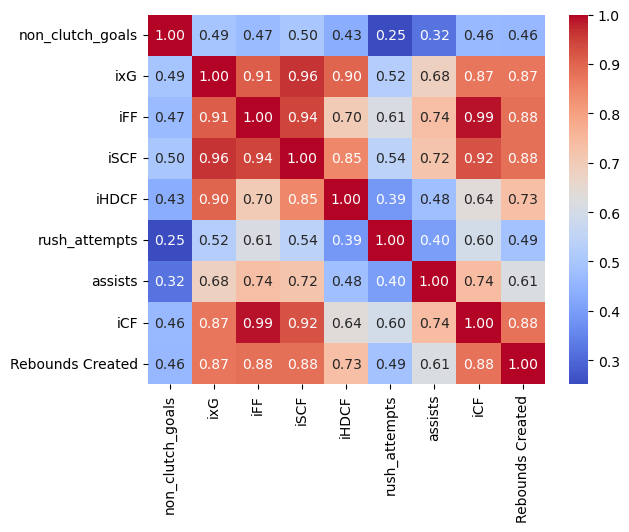

In [35]:

import seaborn as sns

merged_clutch_goals['non_clutch_goals'] = merged_clutch_goals['total_goals'] - (merged_clutch_goals['game_winning_goals'] + merged_clutch_goals['goals_down_by_one'] + merged_clutch_goals['goals_up_by_one'] + merged_clutch_goals['goals_when_tied'])


x_var = ['non_clutch_goals','ixG', 'iFF', 'iSCF', 'iHDCF', 'rush_attempts', 'assists', 'iCF', 'Rebounds Created']
X_adjusted = merged_clutch_goals[x_var]

corr_matrix = X_adjusted.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [37]:
threshold_elite = merged_clutch_goals['clutch_score'].quantile(0.85)
threshold_high = merged_clutch_goals['clutch_score'].quantile(0.7)
threshold_average = merged_clutch_goals['clutch_score'].quantile(0.5)


def label_clutchness(row):
    clutch_score = row['clutch_score']
    if clutch_score >= threshold_elite:
        return 1
    else:
        return 0

merged_clutch_goals['clutch_label'] = merged_clutch_goals.apply(label_clutchness, axis=1)

In [ ]:
merged_clutch_goals['clutch_label'].value_counts()

In [ ]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 'rush_attempts_per_game', 'non_clutch_goals_per_]
y_var = 'clutch_label'

X = merged_clutch_goals[x_var]
y = merged_clutch_goals[y_var]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2, stratify = y)
xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
xgb_model.fit(train_x, train_y)

In [ ]:
skf = StratifiedKFold(n_splits=10)

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

scores = cross_validate(xgb_model, X, y, cv = skf, scoring = scoring)

df_scores = pd.DataFrame.from_dict(scores)

df_scores.mean()

In [ ]:
cv = StratifiedKFold(n_splits=10)

train_sizes = np.linspace(0.1, 1.0, 10)
    
train_sizes, train_scores, valid_scores = learning_curve(
    xgb_model, X, y, 
    cv=cv,
    n_jobs=-1,
    train_sizes=train_sizes,
    scoring='neg_log_loss',
)

train_mean = -np.mean(train_scores, axis=1)
train_std = -np.std(train_scores, axis=1)
valid_mean = -np.mean(valid_scores, axis=1)
valid_std = -np.std(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')

plt.title(f'Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('Log Loss')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
plot_importance(xgb_model)
plt.show()

In [ ]:
merged_clutch_goals.columns

In [ ]:
from skopt import BayesSearchCV
import xgboost as xgb
import time
import math
from skopt.space import Integer, Real
from scipy.stats import randint, uniform
from skopt.space import Real, Integer, Categorical

param_grid = {
    'max_depth': Integer(2,5),  # Reduced from 5 to limit complexity
    'min_child_weight': Integer(2,3),  # Increased to prevent overfitting
    'n_estimators': Integer(200, 300),  # Narrowed based on your curves
    'learning_rate': Real(0.03, 0.04),  # Slightly lower than current ~0.14
    'reg_alpha': Real(0.75, 1.9),  # Reduced from current ~1.87
    'reg_lambda': Real(0.75, 1.9),  # Reduced from current ~2.92
    'subsample': Real(0.7, 1),  # Slightly higher than current ~0.74
    'colsample_bytree': Real(0.7, 1)  # Higher than current ~0.64
}


def learning_rate_schedule(iteration):
    return 0.1 * (0.99 ** iteration)

# Modified fit parameters
fit_params = {
    'early_stopping_rounds': 35,  # More aggressive stopping
}


In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
import xgboost as xgb

cv = StratifiedKFold(n_splits=10)

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
best_hyperparams_list = []

def plot_learning_curves(estimator, X, y, cv, iteration, title):

    train_sizes = np.linspace(0.1, 1.0, 10)
    
    # Calculate learning curves
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y, 
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='neg_log_loss'
    )

    # Calculate mean and std
    train_mean = -np.mean(train_scores, axis=1)
    train_std = -np.std(train_scores, axis=1)
    valid_mean = -np.mean(valid_scores, axis=1)
    valid_std = -np.std(valid_scores, axis=1)
    
    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue')
    
    plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')
    
    plt.title(f'Learning Curves - Iteration {iteration}\n{title}')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


for _ in range(1):
    rs = np.random.randint(1, 1000)

    train_x, test_x, train_y, test_y = train_test_split(
    X_adjusted, 
    y, 
    test_size=0.2, 
    stratify=y,
    random_state = rs
    )

    class_weights = compute_sample_weight(class_weight='balanced', y=train_y)
    
    xgb_model_adjusted = xgb.XGBClassifier(n_estimators = 100, eval_metric = 'logloss')
    xgb_model_adjusted.fit(train_x, train_y, sample_weight = class_weights)

    random_search = BayesSearchCV(xgb_model_adjusted, param_grid, cv=cv, n_iter=20, scoring= ['recall'], refit='recall', n_jobs = -1, fit_params = fit_params)

    new = random_search.fit(train_x,train_y)

    xgb_best_model = new.best_estimator_
    
    title = f'Best Parameters: {random_search.best_params_}'
    #plot_learning_curves(xgb_best_model, train_x, train_y, cv, _+1, title)

  
    y_pred = xgb_best_model.predict(test_x)
    y_pred_prob = xgb_best_model.predict_proba(test_x)  # Probabilities for all classes

    # Metrics
    accuracy = accuracy_score(test_y, y_pred)
    precision = precision_score(test_y, y_pred, zero_division=0)
    recall = recall_score(test_y, y_pred)
    f1 = f1_score(test_y, y_pred)
    print(accuracy)
    print(precision)
    print(recall)
    print(f1)

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    best_hyperparams_list.append(random_search.best_params_)

print("Average Accuracy:", np.mean(accuracy_list))
print("Average Precision:", np.mean(precision_list))
print("Average Recall:", np.median(recall_list))
print("Average F1 Score:", np.mean(f1_list))

hyperparams_df = pd.DataFrame(best_hyperparams_list)
averaged_hyperparams = hyperparams_df.mean()
print("Averaged Hyperparameters:")
print(averaged_hyperparams)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(test_y, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.suptitle('Confusion Matrix for XGBoost')
plt.show()

In [ ]:
results = pd.DataFrame({'Actual': test_y, 'Predicted': y_pred})
misclassifications = results[results['Actual'] == 1]
print(misclassifications)

In [ ]:
y_pred_prob

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    xgb_best_model, test_x, test_y
)
_ = display.ax_.set_title("2-class Precision-Recall curve")


In [ ]:
merged_clutch_goals.loc[82]

In [129]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.svm import SVR 
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

x_var = ['shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'rush_attempts', 'assists', 'iCF', 'Rebounds Created']
X_adjusted = merged_clutch_goals[x_var]
y_var = 'clutch_score'  
y = merged_clutch_goals[y_var]

train_x, test_x, train_y, test_y = train_test_split(
    X_adjusted, 
    y, 
    test_size=0.2, 
    random_state=1111
)

xgb_model = XGBRegressor(n_estimators = 100)
xgb_model.fit(train_x, train_y)
kf = KFold(n_splits=10)

scoring = ['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_error']
scores = cross_validate(xgb_model, train_x, train_y, cv=kf, scoring=scoring)

df_scores = pd.DataFrame.from_dict(scores)
print("Cross-validation Results:")
print(df_scores.mean())

Cross-validation Results:
fit_time                            0.114944
score_time                          0.012268
test_neg_root_mean_squared_error   -1.988889
test_r2                             0.449694
test_neg_mean_absolute_error       -1.525828
dtype: float64


In [167]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_validate
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Load the data
x_var = ['shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'rush_attempts', 'assists', 'iCF', 'Rebounds Created']
X_adjusted = merged_clutch_goals[x_var]
y_var = 'clutch_score'
y = merged_clutch_goals[y_var]

# Define the quantiles you want to model
quantiles = [0.5, 0.75, 0.9]

# Set up cross-validation
kf = KFold(n_splits=10, random_state=42, shuffle=True)

# Initialize a dictionary to store the results
results = {}

# Perform cross-validation for each quantile
for q in quantiles:
    model = GradientBoostingRegressor(loss='quantile', alpha=q, n_estimators=100)
    scores = cross_validate(model, X_adjusted, y, cv=kf, scoring=['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_error'])
    results[f'Quantile {q}'] = {
        'RMSE': -scores['test_neg_root_mean_squared_error'].mean(),
        'R2': scores['test_r2'].mean(),
        'MAE': -scores['test_neg_mean_absolute_error'].mean()
    }

# Print the results
for quantile, metrics in results.items():
    print(f"{quantile}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.3f}")

Quantile 0.5:
  RMSE: 1.692
  R2: 0.616
  MAE: 1.265
Quantile 0.75:
  RMSE: 1.864
  R2: 0.515
  MAE: 1.495
Quantile 0.9:
  RMSE: 2.383
  R2: 0.197
  MAE: 2.029


In [149]:
from skopt import BayesSearchCV
import xgboost as xgb
import time
import math
from skopt.space import Integer, Real
from scipy.stats import randint, uniform
from skopt.space import Real, Integer, Categorical

from skopt.space import Integer, Real

param_grid = {
    'n_estimators': Integer(100, 150),              # Number of trees/estimators
    'learning_rate': Real(0.01, 0.02),               # Controls the learning rate
    'max_depth': Integer(2, 5),                      # Maximum depth of each tree
    'min_samples_split': Integer(2, 10),             # Minimum number of samples required to split an internal node
    'subsample': Real(0.7, 1),                       # Fraction of samples used for fitting each tree
    'alpha': Real(0.5, 0.9)                          # Quantile regression (controls quantile for loss)
}

def learning_rate_schedule(iteration):
    return 0.1 * (0.99 ** iteration)

# Modified fit parameters
fit_params = {
    'early_stopping_rounds': 35,  # More aggressive stopping
}

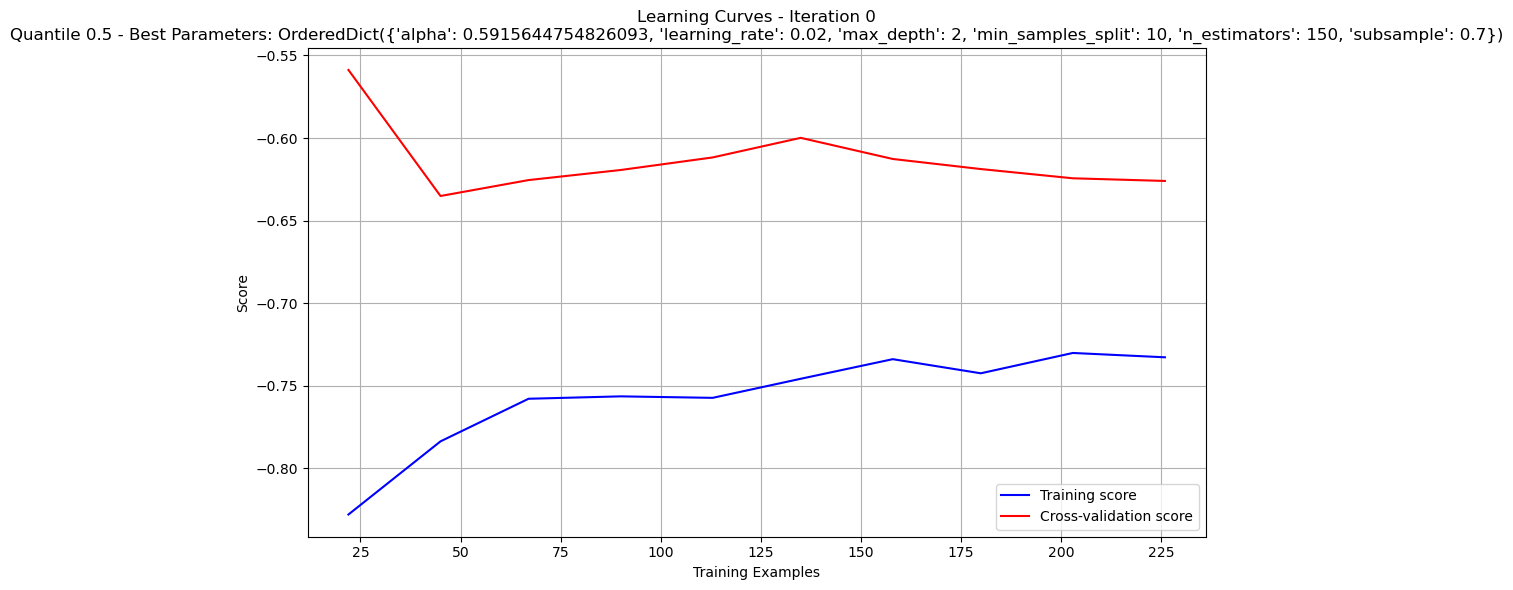

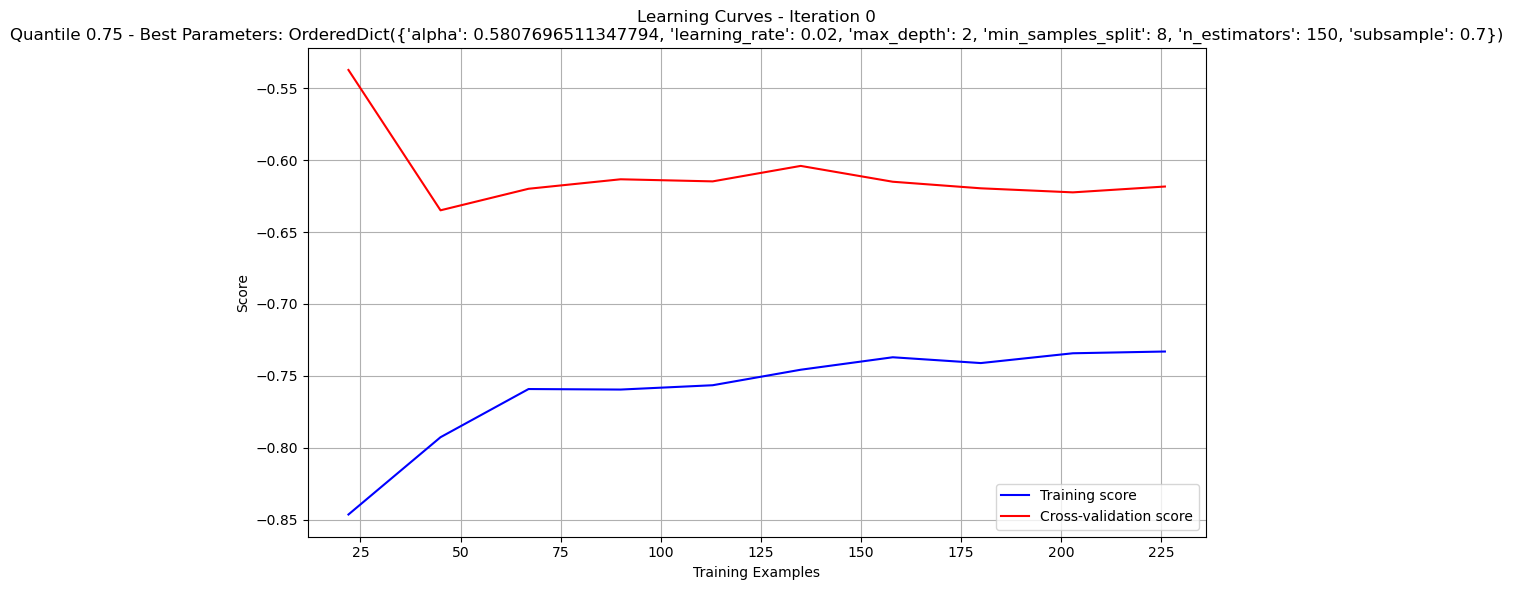

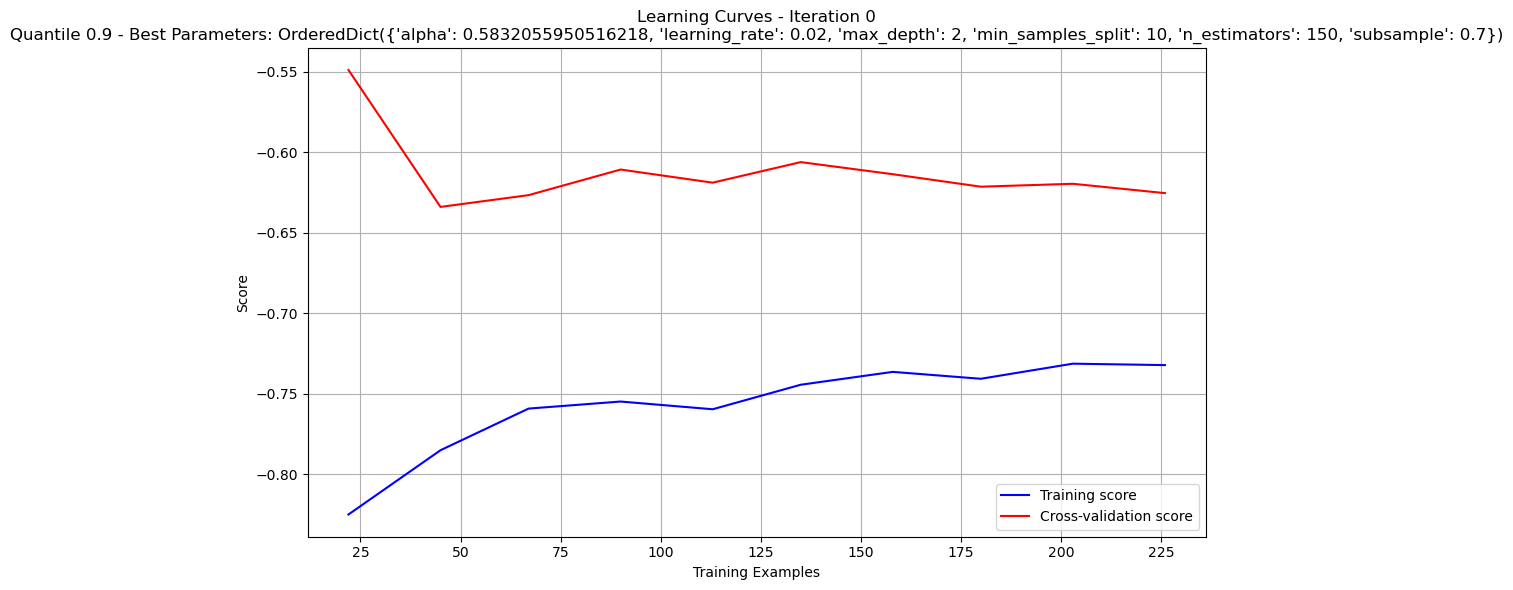

In [151]:
for quantile in [0.5, 0.75, 0.9]:
    random_search = BayesSearchCV(
        GradientBoostingRegressor(loss='quantile', alpha=quantile),
        param_grid,
        cv=kf,
        n_iter=20,
        scoring='neg_root_mean_squared_error',
        refit='neg_root_mean_squared_error',
        n_jobs=-1,
        random_state=1111
    )
    random_search.fit(train_x, train_y)
    xgb_best_model = random_search.best_estimator_
    
    # Plotting learning curves
    title = f'Quantile {quantile} - Best Parameters: {random_search.best_params_}'
    plot_learning_curves(xgb_best_model, train_x, train_y, kf, _, title)
    
    # Predictions on test set
    y_pred = xgb_best_model.predict(test_x)
    
    # Calculate regression metrics
    mse = mean_squared_error(test_y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_y, y_pred)
    r2 = r2_score(test_y, y_pred)
    
    # Append the results
    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)
    best_hyperparams_list.append(random_search.best_params_)

In [163]:
print(rmse_list)

[1.5766448658907872, 1.56581348430113, 1.597198092900572]


In [165]:
results = pd.DataFrame({'Player': merged_clutch_goals.loc[test_y.index, 'Player'], 'Actual': test_y, 'Predicted': y_pred})

# Calculate the absolute error between predicted and actual values
results['Error'] = abs(results['Actual'] - results['Predicted'])
results.sort_values(by=['Error'], inplace = True, ascending = False)

# Print all results
print("All predictions and actual values:")
print(results.head(50))

All predictions and actual values:
                Player  Actual  Predicted     Error
138       Sam Reinhart   15.49   8.947765  6.542235
150     David Pastrnak   13.78   9.721809  4.058191
197    Kirill Kaprizov   12.80   9.390459  3.409541
68    Vincent Trocheck    6.10   9.265439  3.165439
116         Miles Wood    1.35   4.326576  2.976576
295        Tim Stützle    4.67   7.146637  2.476637
58        Tyler Seguin    6.91   4.466972  2.443028
80      Mark Scheifele    7.57   5.349943  2.220057
10        Trevor Lewis    1.71   3.799569  2.089569
147       Robby Fabbri    5.15   3.234710  1.915290
31        John Tavares    7.38   9.283488  1.903488
61          Bryan Rust    8.71   6.807351  1.902649
214        Noah Gregor    1.43   3.119208  1.689208
47       Tyler Toffoli    6.20   7.836657  1.636657
5         Anze Kopitar    5.93   4.313906  1.616094
81      Sean Couturier    3.38   4.875342  1.495342
298    Alexander Holtz    5.12   3.638159  1.481841
174  Christian Fischer    1.3

In [169]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.svm import SVR  # Importing Support Vector Regression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define features and target variable
x_var = ['shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'rush_attempts', 'assists', 'iCF', 'Rebounds Created']
X_adjusted = merged_clutch_goals[x_var]
y_var = 'clutch_score'  # Predict the continuous clutch score directly
y = merged_clutch_goals[y_var]

# Split the data into train and test sets
train_x, test_x, train_y, test_y = train_test_split(
    X_adjusted, 
    y, 
    test_size=0.2, 
    random_state=250
)

# Initialize the SVR model (using a radial basis function kernel)
svr_model = SVR(kernel='rbf', C=100, epsilon=0.1)

# Fit the model on the training set
svr_model.fit(train_x, train_y)

# Perform cross-validation using KFold
kf = KFold(n_splits=10)

# Define the regression metrics for evaluation
scoring = ['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_error']

# Cross-validate the model (on the entire dataset)
scores = cross_validate(svr_model, train_x, train_y, cv=kf, scoring=scoring)

# Convert the scores into a DataFrame for easier analysis
df_scores = pd.DataFrame.from_dict(scores)

# Print the mean scores for each metric
print("Cross-validation Results:")
print(df_scores.mean())


Cross-validation Results:
fit_time                            0.008874
score_time                          0.003792
test_neg_root_mean_squared_error   -1.513189
test_r2                             0.714282
test_neg_mean_absolute_error       -1.153623
dtype: float64


In [189]:
from skopt import BayesSearchCV
from sklearn.svm import SVR
from skopt.space import Real, Integer, Categorical
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Define features and target variable
x_var = ['shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'rush_attempts', 'assists', 'iCF', 'Rebounds Created']
X_adjusted = merged_clutch_goals[x_var]
y_var = 'clutch_score'  # Predict the continuous clutch score directly
y = merged_clutch_goals[y_var]

# Split the data into train and test sets
train_x, test_x, train_y, test_y = train_test_split(
    X_adjusted, 
    y, 
    test_size=0.2, 
    random_state=1111
)

# Define the hyperparameter search space for SVR
param_grid_svr = {
    'C': Real(0.1, 100, prior='log-uniform'),        # Regularization parameter
    'epsilon': Real(0.01, 0.1),                      # Epsilon (the margin of tolerance)
    'kernel': Categorical(['rbf']), # Kernel type
    'degree': Integer(2, 5),                          # Degree of the polynomial kernel (if 'poly')
    'gamma': Categorical(['scale'])           # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
}

# Initialize the SVR model
svr_model = SVR()

# Use BayesSearchCV for hyperparameter optimization
bayes_search_svr = BayesSearchCV(
    svr_model,                 # Model to optimize
    param_grid_svr,            # Hyperparameter search space
    n_iter=4,                 # Number of iterations for optimization
    cv=5,                      # Cross-validation splits
    n_jobs=-1,                 # Use all available processors
    random_state=42            # For reproducibility
)

# Fit the model to the data
bayes_search_svr.fit(train_x, train_y)

# Print the best hyperparameters
print(f"Best hyperparameters: {bayes_search_svr.best_params_}")

# Optionally, you can use the best model for prediction and evaluation
best_svr_model = bayes_search_svr.best_estimator_
y_pred = best_svr_model.predict(test_x)

# Calculate and print regression metrics (for evaluation)
mse = mean_squared_error(test_y, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print(f"Test Set MSE: {mse}")
print(f"Test Set RMSE: {rmse}")
print(f"Test Set MAE: {mae}")
print(f"Test Set R²: {r2}")


Best hyperparameters: OrderedDict({'C': 32.52108800594495, 'degree': 5, 'epsilon': 0.03730690988957575, 'gamma': 'scale', 'kernel': 'rbf'})
Test Set MSE: 2.3644180030753392
Test Set RMSE: 1.5376664147582009
Test Set MAE: 1.053052578499089
Test Set R²: 0.7133183082737922


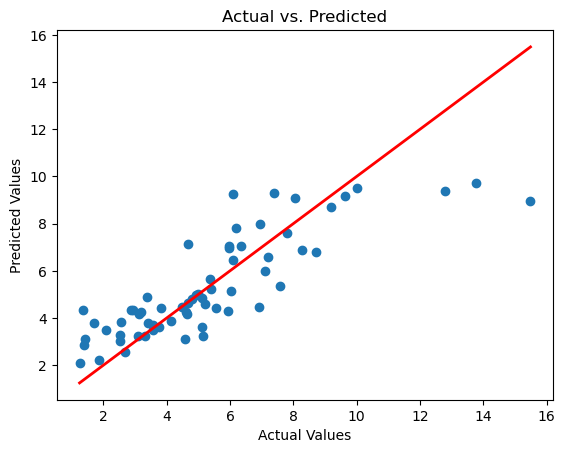

In [191]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have your model's predictions and the actual values
y_pred = xgb_best_model.predict(test_x)  # Replace with your model's predictions
y_test = test_y  # Actual target values

# Scatter plot of Actual vs Predicted
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)  # Ideal line (y = x)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

In [193]:
results = pd.DataFrame({'Player': merged_clutch_goals.loc[test_y.index, 'Player'], 'Actual': test_y, 'Predicted': y_pred})

# Calculate the absolute error between predicted and actual values
results['Error'] = abs(results['Actual'] - results['Predicted'])
results.sort_values(by=['Error'], inplace = True, ascending = False)

# Print all results
print("All predictions and actual values:")
print(results.head(50))

All predictions and actual values:
                Player  Actual  Predicted     Error
138       Sam Reinhart   15.49   8.947765  6.542235
150     David Pastrnak   13.78   9.721809  4.058191
197    Kirill Kaprizov   12.80   9.390459  3.409541
68    Vincent Trocheck    6.10   9.265439  3.165439
116         Miles Wood    1.35   4.326576  2.976576
295        Tim Stützle    4.67   7.146637  2.476637
58        Tyler Seguin    6.91   4.466972  2.443028
80      Mark Scheifele    7.57   5.349943  2.220057
10        Trevor Lewis    1.71   3.799569  2.089569
147       Robby Fabbri    5.15   3.234710  1.915290
31        John Tavares    7.38   9.283488  1.903488
61          Bryan Rust    8.71   6.807351  1.902649
214        Noah Gregor    1.43   3.119208  1.689208
47       Tyler Toffoli    6.20   7.836657  1.636657
5         Anze Kopitar    5.93   4.313906  1.616094
81      Sean Couturier    3.38   4.875342  1.495342
298    Alexander Holtz    5.12   3.638159  1.481841
174  Christian Fischer    1.3

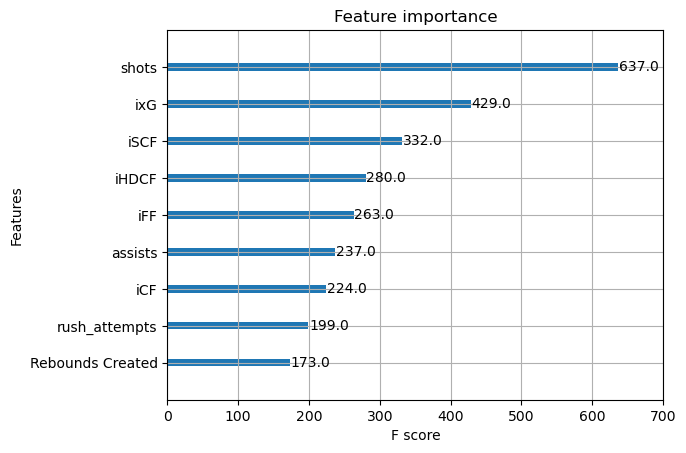

In [539]:
plot_importance(xgb_model_regression)
plt.show()

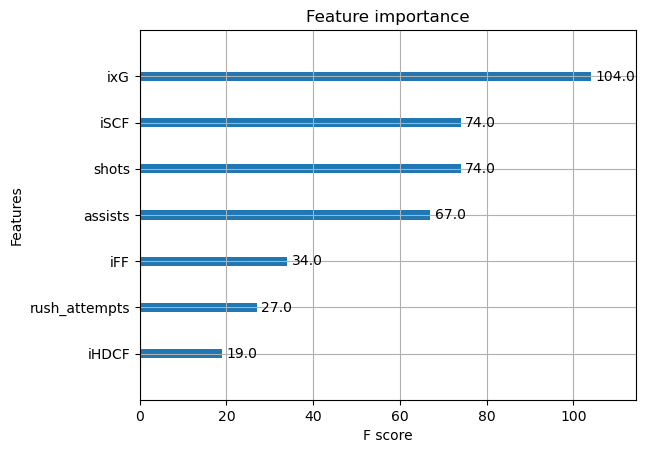

In [543]:
results = pd.DataFrame({'Player': merged_clutch_goals.loc[test_y.index, 'Player'], 'Actual': test_y, 'Predicted': y_pred})

# Calculate the absolute error between predicted and actual values
results['Error'] = abs(results['Actual'] - results['Predicted'])
results.sort_values(by=['Error'], inplace = True, ascending = False)

# Print all results
print("All predictions and actual values:")
print(results.head(50))

All predictions and actual values:
                Player  Actual  Predicted     Error
205    Auston Matthews   18.15   8.408568  9.741432
133     Anthony Mantha    7.57   3.274798  4.295202
150     David Pastrnak   13.78   9.659214  4.120786
203    Matthew Tkachuk    5.50   9.329239  3.829239
96      Filip Forsberg   11.95   8.579214  3.370786
193     Artemi Panarin   12.20   8.941955  3.258045
272     Nils Hoglander    6.75   3.683527  3.066473
287      Lucas Raymond    8.05   5.028583  3.021417
83          Joel Armia    5.45   3.432146  2.017854
295        Tim Stützle    4.67   6.406709  1.736709
291        Seth Jarvis    8.27   6.554093  1.715907
231   Elias Pettersson    8.78   7.206295  1.573705
121       Ryan Hartman    6.35   4.818435  1.531565
177     Travis Konecny    9.87   8.351904  1.518096
189       Jake DeBrusk    3.75   5.221947  1.471947
233        Nick Suzuki    7.56   6.089637  1.470363
237       Morgan Frost    2.96   4.390492  1.430492
142     Nikolaj Ehlers    7.5

In [465]:
merged_clutch_goals.loc[205]

playerId                                    8479318
Player                              Auston Matthews
positionCode                                      C
gamesPlayed                                      81
assists                                          38
ot_goals                                          3
game_winning_goals                                8
regulation_game_winning                           5
goals_up_by_one                                  14
goals_down_by_one                                17
goals_when_tied                                  20
total_goals                                      69
shots                                           369
ixG                                           44.61
iFF                                             534
iSCF                                            440
iHDCF                                           194
rush_attempts                                    18
iCF                                             694
Rebounds Cre

In [161]:
test_y.index

Index([228,  61, 146,  73,  23, 222,  28, 169, 145,  55, 230, 157, 299,   1,
       252,  77,  42, 126, 312, 181, 193, 281, 159, 260, 235,  64, 282, 294,
       113, 136, 112, 295,  31, 263, 201, 153,  34, 166, 202,  94, 255, 198,
        22,  79,  32, 165,  20, 127, 208, 122, 129, 111, 246,  83,  33, 220,
       249, 139, 270, 200, 170,  93, 204, 192],
      dtype='int64')

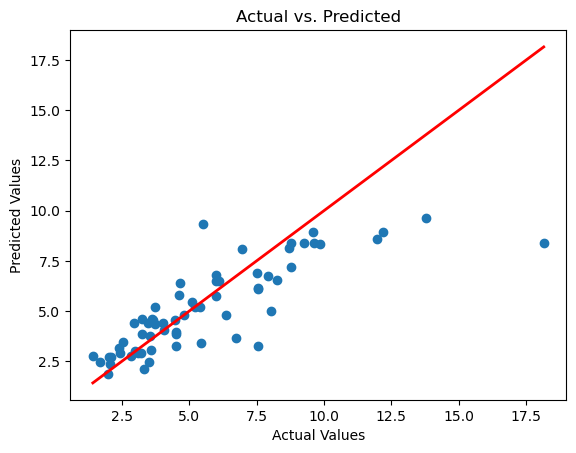

In [545]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have your model's predictions and the actual values
y_pred = xgb_best_model.predict(test_x)  # Replace with your model's predictions
y_test = test_y  # Actual target values

# Scatter plot of Actual vs Predicted
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)  # Ideal line (y = x)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

In [91]:
print(train_y.dtype)
print(np.unique(train_y)) 

float64
[ 0.   0.2  0.4  0.7  0.8  0.9  1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8
  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7  2.8  2.9  3.   3.1  3.2  3.3
  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1  4.2  4.3  4.4  4.5  4.6  4.7
  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5  5.6  5.7  5.8  5.9  6.   6.1
  6.2  6.4  6.6  6.8  6.9  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8
  7.9  8.   8.3  8.4  8.7  8.8  9.   9.2  9.3  9.6  9.8  9.9 10.  10.2
 10.3 10.5 10.7 11.  11.2 12.  12.8 13.8 15.5 18.1]


In [93]:
print(train_x.isnull().sum())  # Check missing values in features
print(np.isnan(train_y).sum())  # Check missing values in target

shots               0
ixG                 0
iFF                 0
iSCF                0
iHDCF               0
rush_attempts       0
assists             0
iCF                 0
Rebounds Created    0
dtype: int64
0


In [325]:
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Assuming you already have your features (X) and target (y)
X = merged_clutch_goals[['shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'rush_attempts', 'assists', 'iCF', 'Rebounds Created']]
y = merged_clutch_goals['clutch_score']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression Model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

# XGBoost Model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Calculate RMSE and R² for both models
rmse_lin = mean_squared_error(y_test, y_pred_lin, squared=False)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)

r2_lin = r2_score(y_test, y_pred_lin)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Output results
print(f"Linear Regression RMSE: {rmse_lin:.4f}")
print(f"XGBoost RMSE: {rmse_xgb:.4f}")
print(f"Linear Regression R²: {r2_lin:.4f}")
print(f"XGBoost R²: {r2_xgb:.4f}")


Linear Regression RMSE: 6.3035
XGBoost RMSE: 6.7359
Linear Regression R²: 0.7294
XGBoost R²: 0.6910


In [327]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Assuming you already have your features (X) and target (y)
X = merged_clutch_goals[['shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'rush_attempts', 'assists', 'iCF', 'Rebounds Created']]
y = merged_clutch_goals['clutch_score']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Ridge and Lasso models
ridge = Ridge()
lasso = Lasso()

# Define parameter grid for tuning alpha (regularization strength)
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# GridSearchCV for Ridge Regression
ridge_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_search.fit(X_train, y_train)

# GridSearchCV for Lasso Regression
lasso_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_search.fit(X_train, y_train)

# Best Ridge model
best_ridge = ridge_search.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)

# Best Lasso model
best_lasso = lasso_search.best_estimator_
y_pred_lasso = best_lasso.predict(X_test)

# Calculate RMSE and R² for both models
rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)
rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)

r2_ridge = r2_score(y_test, y_pred_ridge)
r2_lasso = r2_score(y_test, y_pred_lasso)

# Output results
print(f"Ridge Regression RMSE: {rmse_ridge:.4f}")
print(f"Lasso Regression RMSE: {rmse_lasso:.4f}")
print(f"Ridge Regression R²: {r2_ridge:.4f}")
print(f"Lasso Regression R²: {r2_lasso:.4f}")


Ridge Regression RMSE: 6.2997
Lasso Regression RMSE: 6.2969
Ridge Regression R²: 0.7297
Lasso Regression R²: 0.7299


In [333]:
results = pd.DataFrame({'Player': merged_clutch_goals.loc[y_test.index, 'Player'], 'Actual': y_test, 'Predicted': y_pred_ridge})

# Calculate the absolute error between predicted and actual values
results['Error'] = abs(results['Actual'] - results['Predicted'])
results.sort_values(by=['Error'], inplace = True, ascending = False)

# Print all results
print("All predictions and actual values:")
print(results.head(10))

All predictions and actual values:
                 Player  Actual  Predicted      Error
169         Jack Eichel   47.62  30.188441  17.431559
156       Brayden Point   49.38  35.790693  13.589307
133      Anthony Mantha   27.03  13.741243  13.288757
272      Nils Hoglander   30.00  17.384893  12.615107
197     Kirill Kaprizov   52.00  40.012755  11.987245
93    Zemgus Girgensons   17.46   5.862271  11.597729
44             Nic Dowd   18.75   8.953557   9.796443
258  Jesperi Kotkaniemi    7.59  16.746239   9.156239
5          Anze Kopitar   27.16  18.191061   8.968939
36        Chris Kreider   42.68  34.141128   8.538872
